In [1]:
# Data Processing
import pandas as pd
from PIL import Image
from examples.circle_square.generator import generate_balanced_dataset, draw_shapes
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# LTN
from ltn_imp.automation.knowledge_base import KnowledgeBase
from ltn_imp.automation.data_loaders import LoaderWrapper

## Data Processing

In [2]:
data, metadata = generate_balanced_dataset(100)

data = pd.DataFrame(data)
metadata = pd.DataFrame(metadata)

image_paths = [item for item in data[0]]
images = []

for path in image_paths:
    try:
        img = Image.open(path).convert('RGB')  # Convert to RGB to ensure consistency
        img = np.array(img)
        img_tensor = torch.tensor(img, dtype=torch.float32)  # Convert to PyTorch tensor
        images.append(img_tensor)
    except Exception as e:
        print(f"Error loading image {path}: {e}")

labels = torch.tensor(data[1], dtype=torch.float32)

In [3]:
metadata

circle_center_x  circle_center_y  circle_radius  rect_tl_x  rect_tl_y  \
0                 91               60             10         77         49   
1                 39              105             12         68         92   
2                 97               24             19         50         54   
3                 35               29             19         72        103   
4                 66               32             14         51        108   
..               ...              ...            ...        ...        ...   
295               94               89             13         72        108   
296               67               28             13         51         49   
297               32               90             13         17        112   
298               42               91             10         24        123   
299               88              110             14         73        125   

     rect_br_x  rect_br_y  
0          101          9  
1          117         44  
2           80         22  
3          119         68  
4           88         75  
..         ...        ...  
295        113         59  
296        100         10  
297         61         71  
298         65         79  
299        119         94  

[300 rows x 7 columns]

In [4]:
class ImageDataset(Dataset):
    def __init__(self, images, labels):
        # Convert the list of images to a tensor and permute dimensions to [batch_size, channels, height, width]
        self.images = torch.stack([image.clone().detach().permute(2, 0, 1) for image in images])
        self.labels = labels.clone().detach().float()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

batch_size = 64

# Split the data into training and test sets
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create the training dataset
train_dataset = ImageDataset(train_data, train_labels)

# Create the test dataset
test_dataset = ImageDataset(test_data, test_labels)

# Create the training dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create the test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
pd.DataFrame(labels).value_counts()

0  
0.0    100
1.0    100
2.0    100
Name: count, dtype: int64

In [6]:
print(f"Number of training images: {len(train_data)}")
print(f"Number of training labels: {len(train_labels)}")
print(f"Number of test images: {len(test_data)}")
print(f"Number of test labels: {len(test_labels)}")

Number of training images: 240
Number of training labels: 240
Number of test images: 60
Number of test labels: 60


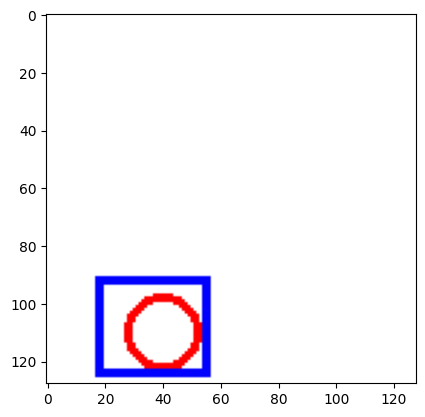

In [7]:
plt.imshow(train_data[0].numpy().astype(np.uint8))

In [8]:
class EvalDataset(Dataset):
    def __init__(self, images, metadata):
        self.images = torch.stack([torch.tensor(image).permute(2, 0, 1) for image in images])
        self.metadata = torch.tensor(metadata).float()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        metadata = self.metadata[idx]
        return image, metadata
    
circle_metadata = metadata[["circle_center_x","circle_center_y", "circle_radius"]]
rectangle_metadata = metadata[["rect_tl_x",	"rect_tl_y"	,"rect_br_x"	,"rect_br_y"]]
train_images, test_images, train_circle_labels, test_circle_labels = train_test_split( images, circle_metadata.values, test_size=0.2, random_state=42)
train_images, test_images, train_rect_labels, test_rect_labels = train_test_split(images, rectangle_metadata.values, test_size=0.2, random_state=42)
test_circle_dataset = EvalDataset(test_images, test_circle_labels)
test_rect_dataset = EvalDataset(test_images, test_rect_labels)

test_circle_dataloader = DataLoader(test_circle_dataset, batch_size=batch_size, shuffle=False)
test_rect_dataloader = DataLoader(test_rect_dataset, batch_size=batch_size, shuffle=False)

/var/folders/mv/_dg3pqgn2zdf7f95_1dg07rw0000gn/T/ipykernel_2026/3954378713.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.images = torch.stack([torch.tensor(image).permute(2, 0, 1) for image in images])


## Models

In [9]:
class CircleDetector(nn.Module):
    def __init__(self):
        super(CircleDetector, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(in_features=64*16*16, out_features=128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(in_features=128, out_features=3)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.bn_fc1(self.fc1(x)))
        x = self.fc2(x)
        c_x, c_y, r = x[:, 0], x[:, 1], torch.abs(x[:, 2])
        return c_x, c_y, r
    
class RectangleDetector(torch.nn.Module):
    def __init__(self):
        super(RectangleDetector, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(in_features=64*16*16, out_features=128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(in_features=128, out_features=4)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.bn_fc1(self.fc1(x)))
        x = self.fc2(x)
        t_x, t_y,b_x, b_y = x[:, 0], x[:, 1], x[:, 2], x[:, 3]
        return t_x, t_y, b_x, b_y

In [10]:
def evaluate_model_circle(model, dataloader, device='cpu'):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            c_x, c_y, r = model(inputs)
            preds = torch.stack((c_x, c_y, r), dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    mae = mean_absolute_error(all_labels, all_preds)
    print(f'Mean Absolute Error for Circle: {mae:.4f}')
    model.train()
    return mae


def evaluate_model_rect(model, dataloader, device='cpu'):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            tl_x, tl_y, br_x, br_y = model(inputs)
            preds = torch.stack((tl_x, tl_y, br_x, br_y), dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    mae = mean_absolute_error(all_labels, all_preds)
    print(f'Mean Absolute Error for Rectangle: {mae:.4f}')
    model.train()
    return mae

## Training

In [11]:
ancillary_rules = [
    # Inside rule
    "forall c1 c2 r t1 t2 b1 b2. Inside(c1, c2, r, t1, t2, b1, b2) <-> (((c1 + r) > t1) and ((c1 - r) < b1) and ((c2 + r) > b2) and ((c2 - r) < t2))",

    # Outside rule
    "forall c1 c2 r t1 t2 b1 b2. Outside(c1, c2, r, t1, t2, b1, b2) <-> (((c1 + r) < t1) or ((c1 - r) > b1) or ((c2 + r) < b2) or ((c2 - r) > t2))",

    # Independent Intersect rule
    "forall c1 c2 r t1 t2 b1 b2 . Intersect(c1, c2, r, t1, t2, b1, b2) <-> ((not Inside(c1, c2, r, t1, t2, b1, b2)) and (not Outside(c1, c2, r, t1, t2, b1, b2)))",
]

learning_rules = [
    "all i. (Circle(i, c1, c2, r) and Rect(i, t1, t2, b1, b2))",
    "all i. ((y == in) ->  Inside(c1, c2, r, t1, t2, b1, b2))",
    "all i. ((y == int) -> Intersect(c1, c2, r, t1, t2, b1, b2))",
    "all i. ((y == out) -> Outside(c1, c2, r, t1, t2, b1, b2))",
]

In [12]:
circle = torch.load("saved_models/circle.pkl")
rectangle = torch.load("saved_models/rect.pkl")

predicates = {
    "Circle": circle,
    "Rect": rectangle,
}

loader = LoaderWrapper(loader=train_dataloader, variables=["i"], targets=["y"])

rule_to_loader = {rule: [loader] for rule in learning_rules }

quantifier_imp = {"forall": "pmean_error"}

constants = {
    "in": torch.tensor([0.]),
    "int": torch.tensor([1.]),
    "out": torch.tensor([2.]),
}

kb = KnowledgeBase(
    predicates=predicates,
    ancillary_rules=ancillary_rules,
    learning_rules=learning_rules,
    rule_to_data_loader_mapping=rule_to_loader,
    quantifier_impls=quantifier_imp,
    constant_mapping=constants
)

/var/folders/mv/_dg3pqgn2zdf7f95_1dg07rw0000gn/T/ipykernel_2026/1411902424.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  circle = torch.load("saved_models/circle.pkl")

In [13]:
idx = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


tensor(0.)


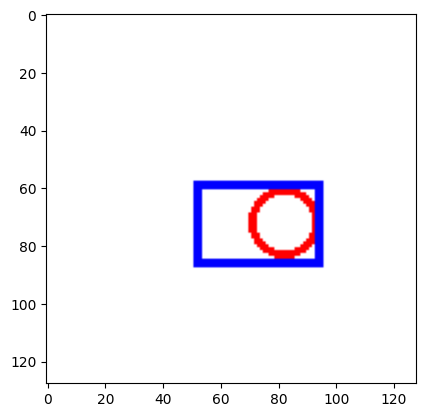

In [14]:
print(test_labels[idx])
plt.imshow(test_data[idx])

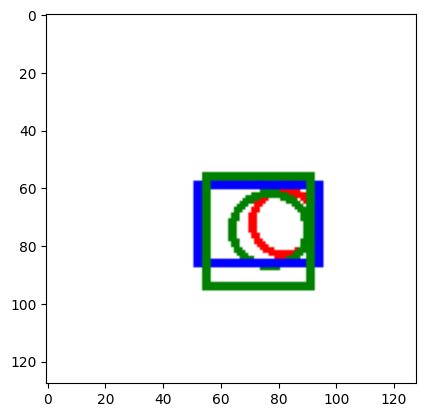

In [15]:
test_circle_data, test_circle_metadata = next(iter(test_circle_dataloader))
test_rect_data, test_rect_metadata = next(iter(test_rect_dataloader))

circle.eval()
circle_instance = test_circle_data[idx].unsqueeze(0)
c_x, c_y, r = circle(circle_instance)

rectangle.eval()
rect_instance = test_rect_data[idx].unsqueeze(0)
t_x, t_y, b_x, b_y = rectangle(rect_instance)

plt.imshow(draw_shapes(*test_rect_metadata[idx], t_x, t_y, b_x, b_y , *test_circle_metadata[idx], c_x, c_y, r))

In [16]:
evaluate_model_circle(circle, test_circle_dataloader, device='cpu')
evaluate_model_rect(rectangle, test_rect_dataloader, device='cpu')
print()

kb.optimize(num_epochs=31, lr=0.001, log_steps=10)

print()
evaluate_model_circle(circle, test_circle_dataloader, device='cpu')
evaluate_model_rect(rectangle, test_rect_dataloader, device='cpu')
print()


Mean Absolute Error for Circle: 3.6397
Mean Absolute Error for Rectangle: 4.9620

{'in': tensor([0.]), 'int': tensor([1.]), 'out': tensor([2.]), 'i': tensor([[[[255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          ...,
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.]],

         [[255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          ...,
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.]],

         [[255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
      

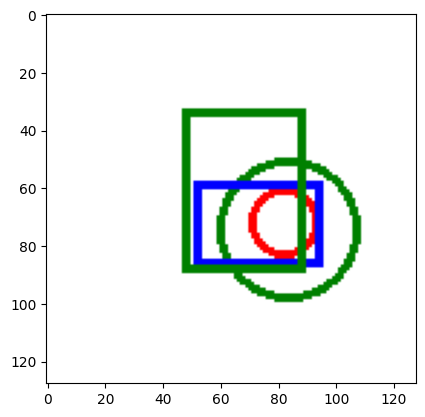

In [17]:
circle.eval()
circle_instance = test_circle_data[idx].unsqueeze(0)
c_x, c_y, r = circle(circle_instance)

rectangle.eval()
rect_instance = test_rect_data[idx].unsqueeze(0)
t_x, t_y, b_x, b_y = rectangle(rect_instance)

plt.imshow(draw_shapes(*test_rect_metadata[idx], t_x, t_y, b_x, b_y , *test_circle_metadata[idx], c_x, c_y, r))

## Computation Graph 

{'in': tensor([0.]), 'int': tensor([1.]), 'out': tensor([2.]), 'i': tensor([[[[255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          ...,
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.]],

         [[255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          ...,
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.]],

         [[255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          ...,
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 25

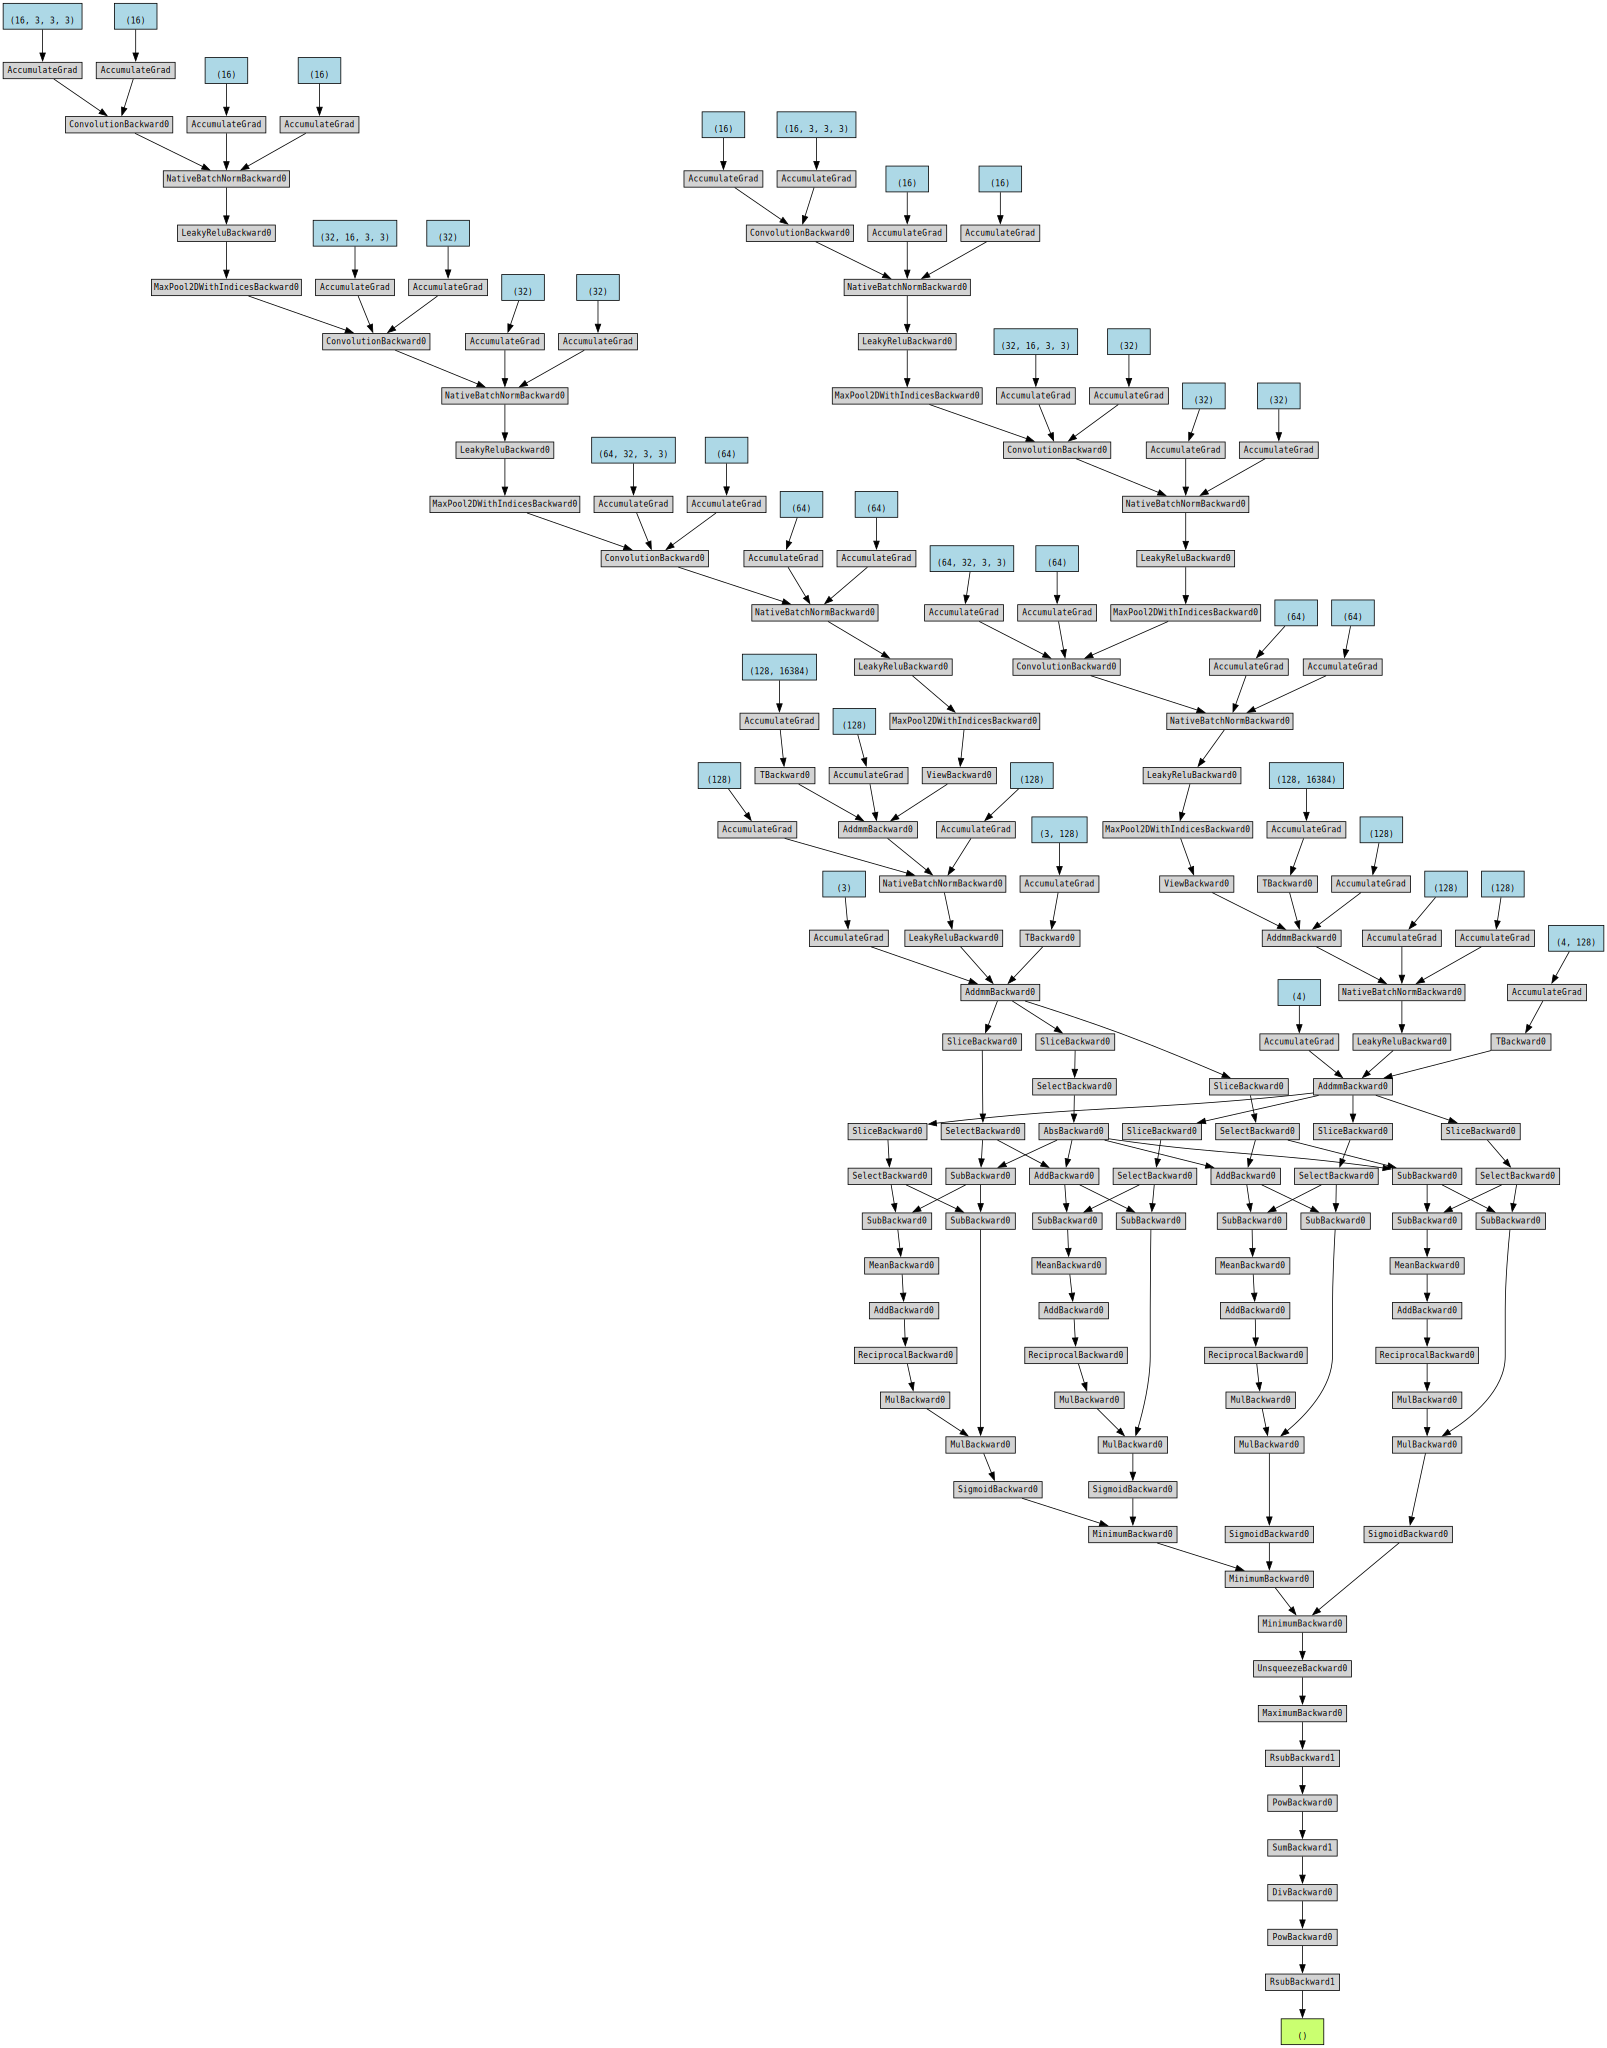

In [18]:
batch = next(iter(train_dataloader))

var_mapping = {}

kb.partition_data(var_mapping,batch, loader )

kb.rules[1].comp_graph(var_mapping)